In [52]:
import seaborn as sns
import pandas as pd


pd.set_option("display.max_columns", None)

In [53]:
steps_df = pd.read_csv("data/10_000_scenarios.csv")
# steps_df = pd.read_csv("data/1000_scenarios_v2.csv")
steps_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5523493 entries, 0 to 5523492
Data columns (total 26 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Unnamed: 0            int64  
 1   overtake_vehicle_num  int64  
 2   velocity              float64
 3   steering              float64
 4   acceleration          float64
 5   step_energy           float64
 6   episode_energy        float64
 7   policy                object 
 8   crash_vehicle         bool   
 9   crash_object          bool   
 10  crash_building        bool   
 11  crash_human           bool   
 12  crash_sidewalk        bool   
 13  out_of_road           bool   
 14  arrive_dest           bool   
 15  max_step              bool   
 16  env_seed              int64  
 17  crash                 bool   
 18  step_reward           float64
 19  cost                  float64
 20  repetition            int64  
 21  action                object 
 22  raw_action            object 
 23  episode

In [54]:
steps_df["out_of_road"].value_counts()

out_of_road
False    5523490
True           3
Name: count, dtype: int64

In [55]:
def drop_boring_columns(df):
    # if a column has one elements its boring lets drop it
    for series_name, series in df.items():
        if len(series.unique()) == 1:
            df = df.drop(series_name, axis=1)
            print(f"Dropped: {series_name}")

    return df


steps_df = drop_boring_columns(steps_df)

Dropped: overtake_vehicle_num
Dropped: policy
Dropped: crash_object
Dropped: crash_building
Dropped: crash_human


In [56]:
grouped = steps_df.groupby(by=["decision_repeat", "env_seed"])
scenarios_df = grouped.last()
# scenarios_df

In [57]:
def validate_termination(s: pd.Series):
    return s["crash"] or s["arrive_dest"] or s["max_step"]


scenarios_df["validate_termination"] = scenarios_df.apply(validate_termination, axis=1)
scenarios_df["validate_termination"].value_counts()

validate_termination
True    30000
Name: count, dtype: int64

In [58]:
assert scenarios_df[
    ~scenarios_df["validate_termination"]
].empty, "Some scenarios termination was not valid!"

In [59]:
# was there any out of road episode?
any_out_of_road = grouped["out_of_road"].agg(any)
any_out_of_road.value_counts()

out_of_road
False    29997
True         3
Name: count, dtype: int64

In [60]:
any_crash = grouped["crash"].agg(any)
any_crash.value_counts()

crash
False    24848
True      5152
Name: count, dtype: int64

In [61]:
episode_length = grouped["episode_length"].last()
episode_length

decision_repeat  env_seed
5                0           314.0
                 1           226.0
                 2           337.0
                 3           282.0
                 4            92.0
                             ...  
15               9995        129.0
                 9996        219.0
                 9997         84.0
                 9998        115.0
                 9999        148.0
Name: episode_length, Length: 30000, dtype: float64

In [62]:
rq1 = episode_length.groupby("decision_repeat").sum()
rq1

decision_repeat
5     2904864.0
10    1517718.0
15    1070911.0
Name: episode_length, dtype: float64

In [63]:
scenarios_df = pd.concat([any_out_of_road, any_crash], axis=1)
scenarios_df.value_counts()

out_of_road  crash
False        False    24848
             True      5149
True         True         3
Name: count, dtype: int64

In [64]:
oracle = scenarios_df.xs(5, level="decision_repeat")

In [65]:
def count_diffrent(scenario_df: pd.Series):

    x = scenario_df.reset_index(drop=True).compare(oracle.reset_index(drop=True))
    return len(x) / len(scenario_df)

In [66]:
rq2 = scenarios_df.groupby("decision_repeat").apply(count_diffrent)
rq2 = rq2.rename("count_diffrent")

<Axes: xlabel='decision_repeat', ylabel='count_diffrent'>

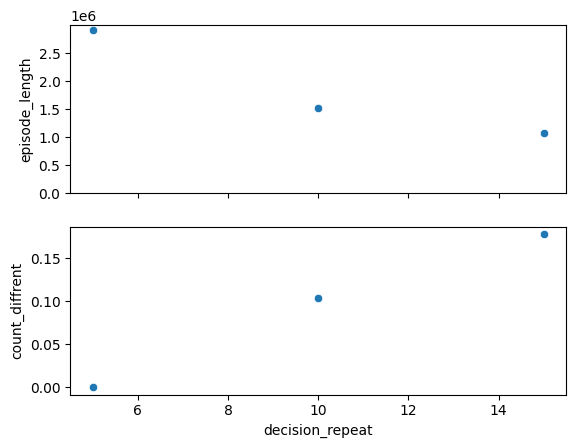

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, sharex=True)

sns.scatterplot(rq1, ax=ax1)
ax1.set_ylim(0)

sns.scatterplot(rq2, ax=ax2)
# ax2.set_ylim((0, 1))